Foreign Function Interface
====

This sectioh shows how to wrap functions or classes from other languages to use in Python. We will only look at examples from C, C++, and Fortran. We will also look at calling R and Matlab functions via line and cell magics.

C
----

### Using `ctypes` to wrap an R function from libRmath

R comes with a standalone C library of special functions and distributions, as described in the [official documentation](https://cran.r-project.org/doc/manuals/r-devel/R-admin.html#The-standalone-Rmath-library). These functions can be wrapped for use in Python.

#### Using `cytpes`

In [1]:
from numpy.ctypeslib import ndpointer
from ctypes import CDLL, c_int, c_double, POINTER

In [2]:
def rnorm(mu=0, sigma=1):
    lib = CDLL('./libRmath.dylib')
    lib.rnorm.argtypes = [c_double, c_double]
    lib.rnorm.restype  = c_double
    return lib.rnorm(mu, sigma)

def dnorm(x, mean=0, sd=1, log=0):
    lib = CDLL('./libRmath.dylib')
    lib.dnorm4.argtypes = [c_double, c_double, c_double, c_int]
    lib.dnorm4.restype  = c_double
    return lib.dnorm4(x, mean, sd, log)

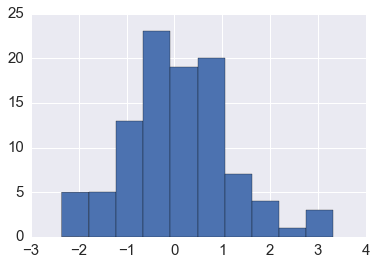

In [3]:
plt.hist([rnorm() for i in range(100)])
pass

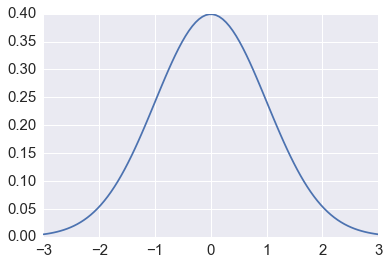

In [4]:
xs = np.linspace(-3,3,100)
plt.plot(xs, list(map(dnorm, xs)))
pass

### Wrapping your own C function

This is rahter unusual - most times we would probably just use Cython or `numba` to compile from Python to C rahter than write a standalone C function. 

#### C header file

In [5]:
%%file c_fib.h
double c_fib(int n);

Overwriting c_fib.h


#### C implementation file

In [6]:
%%file c_fib.c
double c_fib(int n) {
    double tmp, a = 0, b = 1;
    for (int i=0; i<n; i++) {
        tmp = a;
        a = a + b;
        b = tmp;
    }
    return a;
}

Overwriting c_fib.c


#### Cython definition file

In [7]:
%%file cy_fib.pxd
cdef extern from "c_fib.h":
    double c_fib(int n)

Overwriting cy_fib.pxd


#### Cython implementation file

In [8]:
%%file cy_fib.pyx
cimport cy_fib

def fib(n):
    return cy_fib.c_fib(n)

Overwriting cy_fib.pyx


#### Standard way to build a Python module

In [9]:
%%file setup.py
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension("cy_fib",
                sources=["cy_fib.pyx", "c_fib.c"],
                extra_compile_args=["-w"])

setup(name = "Fibonacci numbers",
      ext_modules = cythonize(ext))

Overwriting setup.py


#### Acutally build the module

In [10]:
%%bash
python setup.py -q build_ext --inplace

Compiling cy_fib.pyx because it changed.
[1/1] Cythonizing cy_fib.pyx


In [11]:
import cy_fib

cy_fib.fib(10)

55.0

C++
----

This is almost similar to C. We will use Cython to wrap a simple funciton. 

#### C++ function declaration

In [23]:
%%file add.hpp
#pragma once
int add(int a, int b);

Overwriting add.hpp


#### C++ Function definition

In [24]:
%%file add.cpp
int add(int a, int b) {
    return a+b;
}

Overwriting add.cpp


#### Driver program for testing in C++

In [25]:
%%file driver.cpp
#include <iostream>
#include "add.hpp"
using std::cout;
using std::endl;

int main() {
    cout << add(3, 4) << endl;
}

Overwriting driver.cpp


#### Compile and execute

In [26]:
%%bash
g++ -o driver.exe driver.cpp add.cpp
./driver.exe

7


### Using Cython to build a shared library

#### Helper file to expose C++ functions to Python

In [28]:
%%file plus.pyx

cdef extern from 'add.cpp':
    int add(int a, int b)
    
def plus(a, b):
    return add(a, b)


Overwriting plus.pyx


#### Using distuils to create a build script

The standard approach is to write a `setup.py` file that will build the shared library. The build moudle can then be used elsewhere or installed togetehr with your Python package.

In [35]:
%%file setup.py 
from distutils.core import setup, Extension
from Cython.Build import cythonize

ext = Extension("plus",
                sources=["plus.pyx", "add.cpp"],
                extra_compile_args=["-w"])

setup(
    ext_modules = cythonize(
            ext,
            language="c++",        
      ))

Overwriting setup.py


#### Build module

In [36]:
%%bash
python setup.py -q build_ext --inplace

Compiling plus.pyx because it changed.
[1/1] Cythonizing plus.pyx


#### Using C++ function in Pyhton

In [37]:
import plus

plus.plus(3, 4)

7

## Fortran

If there is a message `f2py not found`, create a symbolic link to `f2py3` in the same directory.

In [38]:
%load_ext fortranmagic

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


In [39]:
%%fortran

subroutine fort_sum(N, s)
    integer*8, intent(in) :: N
    integer*8, intent(out) :: s
    integer*8 i
    s = 0
    do i = 1, N
        s = s + i*i
    end do
end 

In [40]:
fort_sum(10)

385

#### Antoher example from the [documentation](http://nbviewer.ipython.org/github/mgaitan/fortran_magic/blob/master/documentation.ipynb)

In [41]:
%%fortran --link lapack

subroutine solve(A, b, x, n)
    ! solve the matrix equation A*x=b using LAPACK
    implicit none

    real*8, dimension(n,n), intent(in) :: A
    real*8, dimension(n), intent(in) :: b
    real*8, dimension(n), intent(out) :: x

    integer :: pivot(n), ok

    integer, intent(in) :: n
    x = b

    ! find the solution using the LAPACK routine SGESV
    call DGESV(n, 1, A, n, pivot, x, n, ok)
    
end subroutine

In [42]:
A = np.array([[1, 2.5], [-3, 4]])
b = np.array([1, 2.5])

solve(A, b)

array([-0.19565217,  0.47826087])

## R

In [45]:
%load_ext rpy2.ipython


The downloaded binary packages are in
	/var/folders/xf/rzdg30ps11g93j3w0h589q780000gn/T//RtmpdLdJIX/downloaded_packages


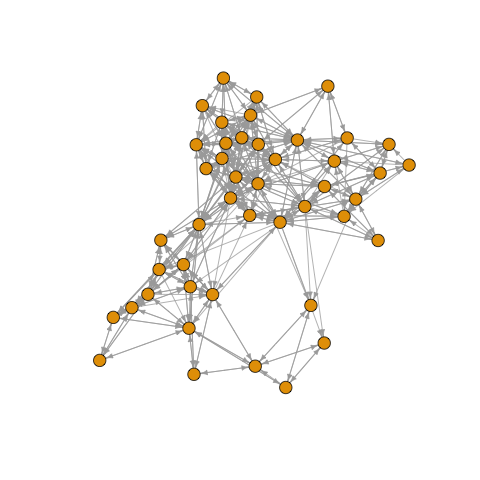

In [47]:
%%R

options(warn=-1)
install.packages("igraphdata", repos = "http://cran.r-project.org")
library(igraph)
library(igraphdata)
data(macaque)
plot(macaque, layout=layout.auto, vertex.shape="circle",
     vertex.size=8, edge.arrow.size=0.5, vertex.label=NA)

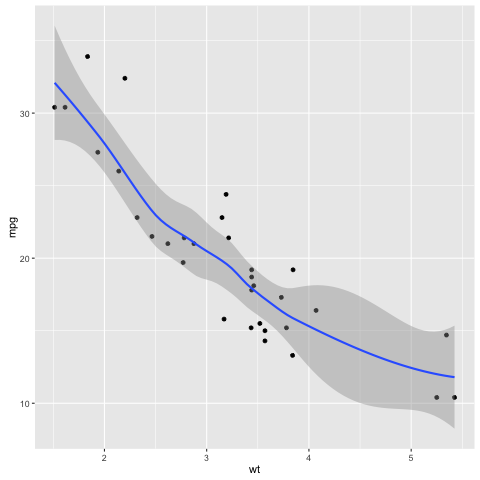

In [49]:
%%R
library(ggplot2)
ggplot(mtcars, aes(x=wt, y=mpg)) + geom_point() + geom_smooth(method=loess)

#### Converting between Python and R

In [51]:
%R -o mtcars

#### `mtcars` is now a Python dataframe

In [52]:
mtcars.head(n=3)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.320,18.61,1,1,4,1


In [53]:
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

#### We can also pass data from Ptyhon to R

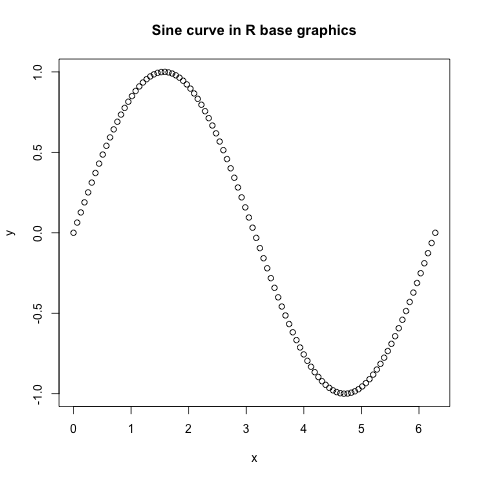

In [55]:
%%R -i x,y
plot(x, y, main="Sine curve in R base graphics")

Matlab
----

There is a similar interface to octave if you prefer open source.

In [1]:
%load_ext pymatbridge

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-054aea7d-c8d5-4d2f-8e0f-fd11618a184f
Send 'exit' command to kill the server
...........MATLAB started and connected!


/Users/cliburn/anaconda/envs/py35/lib/python3.5/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)


In [3]:
%%matlab
M = magic(5)
eigs(M)


M =

    17    24     1     8    15
    23     5     7    14    16
     4     6    13    20    22
    10    12    19    21     3
    11    18    25     2     9


ans =

   13.1263
  -13.1263
   21.2768
  -21.2768
   65.0000



In [4]:
n = 9

#### As usual, we can pass data in and out

In [6]:
%%matlab -i n -o v
M = magic(n)
v = eigs(M)`a


M =

    47    58    69    80     1    12    23    34    45
    57    68    79     9    11    22    33    44    46
    67    78     8    10    21    32    43    54    56
    77     7    18    20    31    42    53    55    66
     6    17    19    30    41    52    63    65    76
    16    27    29    40    51    62    64    75     5
    26    28    39    50    61    72    74     4    15
    36    38    49    60    71    73     3    14    25
    37    48    59    70    81     2    13    24    35


v =

  369.0000
 -118.4141
  118.4141
  -63.0069
   63.0069
   46.4758



In [7]:
v

array([[ 369.        ],
       [-118.41407217],
       [ 118.41407217],
       [ -63.00687636],
       [  63.00687636],
       [  46.47580015]])

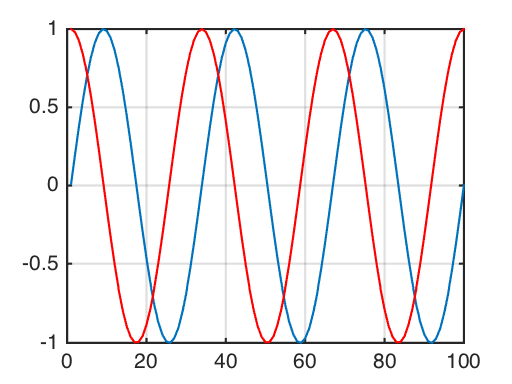

In [2]:
%%matlab 
a = linspace(0.01,6*pi,100);
plot(sin(a))
grid on
hold on
plot(cos(a),'r')

**Exercise**

Wrap the rnorm and dnorm functions from the R standalone library `libRmath` using `cython` instead of `ctypes`.